In [1]:
# Text generating problems are actully classification problems where the labels are all the words in the vocab

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from sklearn.metrics import accuracy_score

import requests, zipfile, io
import os, glob
import shutil

print(tf.__version__)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

2.9.1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


In [3]:
vocab_size = 1000
max_length = 32
embedding_dim = 96
trunc_type='post'
padding_type='pre'
oov_tok = "<OOV>"
SHUFFLE_SIZE=64
BATCH_SIZE = 64
EPOCHS = 500
PATIENCE = 10
MONITOR = 'acc'

In [4]:
text = """In the town of Athy one Jeremy Lanigan
Battered away till he hadn´t a pound
And his father he died and made him a man again,
Left him a farm and ten acres of ground
He gave a grand party to friends and relations
Who did not forget him when come to the wall
If you´d only listen, I´ll make your eyes glisten
At the rows and ructions of Lanigan´s ball
Myself to be sure got free invitations
For all the nice girls and boys I might ask
In less than a minute both friends and relations
Were dancing as merry as bees round a cask
Lashing of punch and wine for the ladies
Potatoes, cakes, there was bacon and tea
There were the Nolans, Dolans, O´Grady´s
Courting the girls and dancing away
Six long months I spent in Dublin
Six long months doing nothing at all
Six long months I spent in Dublin
Learning to dance for Lanigan´s ball
They were doing all kinds of nonsensical polkas
Round the room in a whirly gig
But Julia and I soon banished their nonsense
And tipped them a twist of a real Irish jig
Oh how the girl she really got mad and me
Danced that you´d think that the ceiling would fall
For I spent three weeks at Brooks Academy
Learning to dance for Lanigan´s ball
Six long months I spent in Dublin
Six long months doing nothing at all
Six long months I spent in Dublin
Learning to dance for Lanigan´s ball
And I stepped out - and I stepped in again
Learning to dance for Lanigan´s ball
The boys were as merry, the girls all hearty
Dancing around in couples and groups
Till an accident happened, young Terence McCarthy
He put his right leg through Miss Finerty´s hoops
The creature she fainted and cried "Meelia Murther"
And called for her brothers and gathered them all
Carmody swore that he´d go no further,
Till he had statisfaction at Lanigan´s ball
Six long months I spent in Dublin
Six long months doing nothing at all
Six long months I spent in Dublin
Learning to dance for Lanigan´s ball
Boys, oh boys, ´tis there was ructions
Myself got a kick from big Phelim McHugh
And I soon replied to his kind introduction
And kicked him a terrible hullabaloo
Casey the piper was nearly being strangled
They squeezed up his pipes, bellows, chanters and all
And the girls in their ribbons they all got entangled
And that put an end to Lanigan´s ball
Six long months I spent in Dublin
Six long months doing nothing at all
Six long months I spent in Dublin
Learning to dance for Lanigan´s ball
And I stepped out - and I stepped in again
Learning to dance for Lanigan´s ball"""

text = text.lower().split('\n')
print(text[:5], '\n\n')

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(text)   
print(tokenizer.word_index, '\n\n')


total_words = len(tokenizer.word_index) + 1 
print(total_words)

['in the town of athy one jeremy lanigan', 'battered away till he hadn´t a pound', 'and his father he died and made him a man again,', 'left him a farm and ten acres of ground', 'he gave a grand party to friends and relations'] 


{'and': 1, 'i': 2, 'in': 3, 'the': 4, 'to': 5, 'six': 6, 'long': 7, 'months': 8, 'a': 9, 'for': 10, 'lanigan´s': 11, 'ball': 12, 'all': 13, 'spent': 14, 'dublin': 15, 'at': 16, 'learning': 17, 'dance': 18, 'of': 19, 'he': 20, 'doing': 21, 'his': 22, 'him': 23, 'got': 24, 'girls': 25, 'boys': 26, 'were': 27, 'nothing': 28, 'that': 29, 'stepped': 30, 'till': 31, 'again': 32, 'dancing': 33, 'as': 34, 'there': 35, 'was': 36, 'they': 37, 'away': 38, 'friends': 39, 'relations': 40, 'you´d': 41, 'ructions': 42, 'myself': 43, 'merry': 44, 'round': 45, 'soon': 46, 'their': 47, 'them': 48, 'oh': 49, 'she': 50, 'out': 51, 'an': 52, 'put': 53, 'town': 54, 'athy': 55, 'one': 56, 'jeremy': 57, 'lanigan': 58, 'battered': 59, 'hadn´t': 60, 'pound': 61, 'father': 62, 'died': 

In [5]:
input_sequences = []
j = 0
for line in text:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

    if j == 0:
        print(line)
        print("convert the line of text into a list of the tokens representing the words: ", token_list)
        print("create a number of n-grams sequences: ", input_sequences)
    j=j+1

print(input_sequences[:50])

max_sequence_len = max([len(x) for x in input_sequences])
print("\n\nlength of the longest sentence in the corpus is: ", max_sequence_len)

input_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding=padding_type))
print("pad all of the sequences so that they are the same length:\n",  input_sequences, '\n', max([len(x) for x in input_sequences]))

# create predictors and label
xs, labels = input_sequences[:,:-1], input_sequences[:,-1]
print("xs:\n",xs[:][:3])
print(xs.shape)
print("labels:\n",labels[:][0:3])


ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
print("convert the list to a categorical: put 1 in the index of the labels (encode the labels as it is a classification problem)\n",ys[0],"\n", ys[2])
print(ys.shape, '\n\n')


xtrain = tf.data.Dataset.from_tensor_slices(xs)
ytrain = tf.data.Dataset.from_tensor_slices(ys)
print(xtrain, ytrain)


train_dataset = tf.data.Dataset.zip((xtrain, ytrain)).shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(train_dataset)

in the town of athy one jeremy lanigan
convert the line of text into a list of the tokens representing the words:  [3, 4, 54, 19, 55, 56, 57, 58]
create a number of n-grams sequences:  [[3, 4], [3, 4, 54], [3, 4, 54, 19], [3, 4, 54, 19, 55], [3, 4, 54, 19, 55, 56], [3, 4, 54, 19, 55, 56, 57], [3, 4, 54, 19, 55, 56, 57, 58]]
[[3, 4], [3, 4, 54], [3, 4, 54, 19], [3, 4, 54, 19, 55], [3, 4, 54, 19, 55, 56], [3, 4, 54, 19, 55, 56, 57], [3, 4, 54, 19, 55, 56, 57, 58], [59, 38], [59, 38, 31], [59, 38, 31, 20], [59, 38, 31, 20, 60], [59, 38, 31, 20, 60, 9], [59, 38, 31, 20, 60, 9, 61], [1, 22], [1, 22, 62], [1, 22, 62, 20], [1, 22, 62, 20, 63], [1, 22, 62, 20, 63, 1], [1, 22, 62, 20, 63, 1, 64], [1, 22, 62, 20, 63, 1, 64, 23], [1, 22, 62, 20, 63, 1, 64, 23, 9], [1, 22, 62, 20, 63, 1, 64, 23, 9, 65], [1, 22, 62, 20, 63, 1, 64, 23, 9, 65, 32], [66, 23], [66, 23, 9], [66, 23, 9, 67], [66, 23, 9, 67, 1], [66, 23, 9, 67, 1, 68], [66, 23, 9, 67, 1, 68, 69], [66, 23, 9, 67, 1, 68, 69, 19], [66, 23, 9

In [6]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

3
4
54
19
55
56
57
58


In [7]:
xs[6]

array([ 0,  0,  0,  3,  4, 54, 19, 55, 56, 57])

In [8]:
MODEL_NAME = './models/Generate_NLP_Text_LSTM_full_verse.h5'

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dense(total_words, activation='softmax')
])

# Setup the training parameters
model.compile(
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Nadam(1e-3),
    metrics=['acc']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 96)            19296     
                                                                 
 bidirectional (Bidirectiona  (None, 10, 128)          82432     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 128)          74496     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 48)                6192      
                                                        

Epoch 1/500
7/7 [==============================] - 9s 96ms/step - loss: 5.2979 - acc: 0.0249 - lr: 0.0010
Epoch 2/500
7/7 [==============================] - 0s 34ms/step - loss: 5.2115 - acc: 0.0224 - lr: 0.0010
Epoch 3/500
7/7 [==============================] - 1s 144ms/step - loss: 5.0096 - acc: 0.0274 - lr: 0.0010
Epoch 4/500
7/7 [==============================] - 0s 31ms/step - loss: 4.8807 - acc: 0.0249 - lr: 0.0010
Epoch 5/500
7/7 [==============================] - 0s 31ms/step - loss: 4.7645 - acc: 0.0249 - lr: 0.0010
Epoch 6/500
7/7 [==============================] - 1s 135ms/step - loss: 4.6215 - acc: 0.0348 - lr: 0.0010
Epoch 7/500
7/7 [==============================] - 1s 90ms/step - loss: 4.4999 - acc: 0.0473 - lr: 0.0010
Epoch 8/500
7/7 [==============================] - 0s 75ms/step - loss: 4.4117 - acc: 0.0597 - lr: 0.0010
Epoch 9/500
7/7 [==============================] - 1s 179ms/step - loss: 4.3111 - acc: 0.0721 - lr: 0.0010
Epoch 10/500
7/7 [=========================

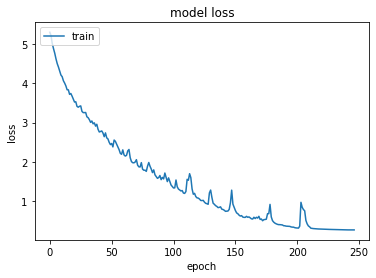

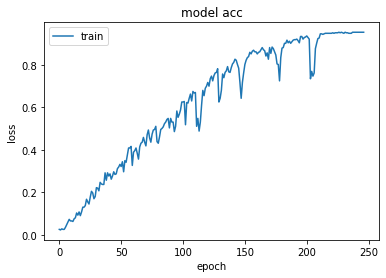

In [9]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-5)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE*2, restore_best_weights=True)]

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    # validation_data=test_dataset,
    callbacks=callbacks
)

# history = model.fit(
#     xs, ys,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     # validation_data=test_dataset,
#     callbacks=callbacks
# )

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
seed_text = "Laurence went to dublin"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    #predicted = model.predict_classes(token_list, verbose=0) # predict_classes used for classifiers (outputs are labels) and it returns the index of the class 
    #predict_classes were removed in TensorFlow version 2.6. so we can use this:
    predict_x=model.predict(token_list) 
    predicted=np.argmax(predict_x,axis=1)

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 15ms/step
Laurence went to dublin i stepped out and i stepped in again again polkas polkas nonsensical polkas polkas academy brooks wall they and again they all hearty ask ask polkas polkas polkas again got entangled friends and relations relations relations relations relations relations brooks got real further fall me me lanigan lanigan brooks lanigan brooks wall friends a ceiling no finerty´s at at lanigan´s ball ball ball nothing dublin polkas polkas polkas polkas polkas might chanters and them a pipes chanters and all i might ask ask ask got entangled entangled wall jig brooks of and a man again finerty´s ball ball lanigan´s ball
